**Import packages and set the global configuration**

In [22]:
%%capture
import pathlib as path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tarfile
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Make it easier to inspect dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)


In [23]:
%%capture
!pip install geopandas
import geopandas as gpd

!pip install wordcloud
from wordcloud import WordCloud, ImageColorGenerator

In [24]:
%%capture
!pip install pyLDAvis==2.1.2

**Download the dataset from the source and unzip it**



In [25]:
%%capture
!wget -O "UNSD — Methodology.csv" "https://drive.google.com/uc?export=download&id=1_bq1smKQrJU34hqXQ256ToxtX97sgZum"
!wget -O "DataPanelWHR2021C2.xls" "https://drive.google.com/uc?export=download&id=1jzIpkPG9YMM1FvSSEuskK1ESjknDjvtE" # happiness dataset
!wget -O "un_dataset" https://dataverse.harvard.edu/api/access/datafile/4590189 # UNGD corpus dataset
!wget -O "API_AG.LND.FRST.ZS_DS2_en_csv_v2_2917381.csv" "https://drive.google.com/uc?export=download&id=1RhyOBX8w-6YgjQT7LSCW5uKHc_zikI7N" # forest dataset

uncompressed_dataset = tarfile.open('un_dataset').extractall()

**Collect tuples that will be used to create the dataframe by traversing all unzipped folders. Metadata are extracted from file names and speeches are preprocessed.**

In [26]:
# Read all files as a list of speeches

def clean_speech(speech: str) -> str:
    """
    Remove unnecessary artifacts from the speech.
    """
    cleaned_speech = speech
    # Replace all kinds of brackets
    # Remove text between square and curly brackets (inclusive). It contains mostly editorial notes.
    cleaned_speech = re.sub(r'\[.*?\]', '', cleaned_speech, re.DOTALL)
    cleaned_speech = re.sub(r'\{.*?\}', '', cleaned_speech, re.DOTALL)

    # Sometimes a huge chunk of a speech can be included between regular brackets, therefore remove parts that are shorter than 150 characters.
    # This number was determined by trial and error to minimize removed speech parts and maximize removed artifacts
    cleaned_speech = re.sub(r'\([^\)]{,150}?\)', '', cleaned_speech, re.DOTALL)

    # Remove composite numbers, like 540-344
    cleaned_speech = re.sub(r'\d+[-/\\]+\d+', '', cleaned_speech)

    # Remove artifacts from file encodings other than UTF-8 (for example \t from UTF-8-BOM)
    cleaned_speech = re.sub(r'\t', '', cleaned_speech)
    
    # Remove remaining artifacts
    cleaned_speech = re.sub(r'[";_=+:\(\)\[\]<>\\]', '', cleaned_speech)

    # Remove repeated spaces
    cleaned_speech = re.sub(r' {2,}', ' ', cleaned_speech)

    return cleaned_speech

all_speeches = []
for file in path.Path('./TXT').glob('*/*.txt'):
    # Remove .txt suffix from the filename
    
    file_name = file.name[:-4]

    if file_name[0] == '.':
      continue
    # Extract country code, session number and year from filename.
    # All names of files follow this pattern
    country, session_number, year = file_name.split('_', maxsplit=3)
    
    # Read all speeches from a single session as a list
    speech = ''
    with open(file, 'r', encoding='utf-8-sig') as file_content:
        speech = file_content.read().replace('\n', '').strip()
        
    # Clean the speech
    speech_cleaned = clean_speech(speech)
    if speech_cleaned == '':
      continue
    # Combine all extracted data along the way into a tuple which will serve as a row in the DataFrame
    all_speeches.append((country, session_number, year, speech_cleaned))

# Create a DataFrame with speech data 
speech_df = pd.DataFrame(all_speeches, columns=['CountryCode','SessionNumber', 'Year', 'Speech'])

#### Merge UNGDC and UNSD-Methodology datasets

In [27]:
#RS
df_speech = speech_df
df_speech['Year'] = df_speech['Year'].astype(int)
df_speech = df_speech.rename(columns={'CountryCode': 'Country Code', 'SessionNumber':'Session'})

In [28]:
#RS & AK
df_codes = pd.read_csv('UNSD — Methodology.csv') #Updated the errors manually on line 67, 126 and 127
df_codes = df_codes[['ISO-alpha3 Code', 'Country or Area', 'Region Name','Sub-region Name','Developed / Developing Countries']]
df_codes = df_codes.rename(columns = {'ISO-alpha3 Code': 'Country Code', 'Country or Area': 'Country'})   # useful for merging

In [29]:
#RS & AK
df_merged = pd.merge(df_codes, df_speech, on='Country Code')

#### Differences in the ISO of Original Speech Data and Merged Data (with UN Methodology file) - 'DDR', 'EU', 'POR', 'YDYE', 'YUG', 'CSK'

In [30]:
#RS

a1=df_speech['Country Code'].unique().tolist()
a2=df_merged['Country Code'].unique().tolist()
new_list = list(set(a1).difference(a2))
new_list

['CSK', 'YDYE', 'POR', 'EU', 'YUG', 'DDR']

In [31]:
speech_df.replace(to_replace='POR', value='PRT', inplace=True)
speech_df.replace(to_replace='DDR', value='DEU', inplace=True)

#### Plot number of sessions for each country in world map


(-198.0, 198.00000000000006, -62.5540835, 90.17549349999999)

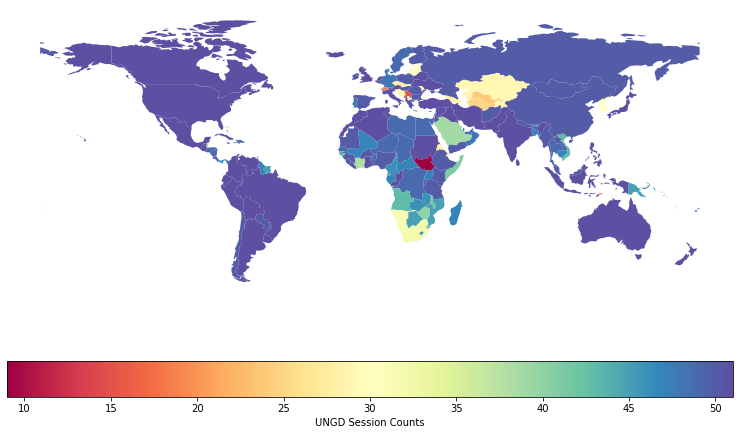

In [32]:
#RS

#df for separating total session counts per country
df_tot_sessions = pd.DataFrame(df_merged.groupby('Country Code').count().sort_values(by="Session")['Session'])
df_tot_sessions.reset_index(inplace=True)

#read geopandas data set for world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

#merge world data from geopandas with total session counts per country
df_tot_sessions1=world.merge(df_tot_sessions, how='left', left_on='iso_a3',right_on='Country Code')

#drop na values
df_tot_sessions1.dropna(inplace=True)

#plot the world map
df_tot_sessions1.plot("Session", figsize=(13,8), cmap='Spectral', legend=True, legend_kwds={'label': "UNGD Session Counts",'orientation': "horizontal"})
plt.axis('off')

#### Calculate word frequencies and show word cloud

In [33]:
#RS & SE

#Most frequent words in all the speech texts all together removing also non-informative words
#We can start categorizing topics from the rest of the words

from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords

def preprocess(words):
    sw = stopwords.words("english")

    #example of list of non informative words (could be a column of non informative words (clustered))
    newStopWords = ['united','nations', 'would', 'support', 'also', 'many', 'like', 'countries', 'must', 'us','new', 'one', 'see','way', 
                    'session', 'well', 'view','un','made','still','may','even','since','per','cent']
    sw.extend(newStopWords) #append to sw like so

    no_sw = []
    for w in words:
        if (w not in sw):
            no_sw.append(w)
    return no_sw

text = " ".join(df_merged["Speech"].to_list())
words = word_tokenize(text)
words = [w.lower() for w in words if w.isalpha()]
words = preprocess(words)

freq = FreqDist(words)

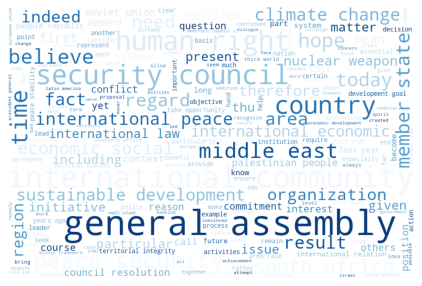

In [34]:
#RS

#Wordcloud of the most frequent words in the UNGD corpus
wc = WordCloud(width=900, height=600, colormap="Blues", background_color='white').generate(" ".join(words))
plt.figure(figsize=(15, 5))
plt.imshow(wc)
plt.axis('off')
plt.show()

#### Merge current dataset with happiness dataset

In [35]:
#RS & AK
df_happiness=pd.read_excel('DataPanelWHR2021C2.xls')
df_happiness = df_happiness.rename(columns = {'Country name':'Country','year': 'Year'})

In [36]:
#RS & AK
df_merged_happiness = pd.merge(df_merged, df_happiness,on=['Country', 'Year']).set_index(['Country Code', 'Year'])

#### Merge current dataset with forestation dataset

In [37]:
#SE

FLdata = pd.read_csv('API_AG.LND.FRST.ZS_DS2_en_csv_v2_2917381.csv') #read in Forest data 

FLdata.drop(FLdata.loc[:, 'Forest area (% of land area)':'2004'], inplace=True, axis=1) #remove data for the years 1990-2004

forestation_df = FLdata.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Forest Land %") #convert columns 2005-2020 to Year column 
forestation_df['Year'] = forestation_df['Year'].astype(int) 

df_merged_happiness = pd.merge(df_merged_happiness, forestation_df, on=['Country Code', 'Year']).set_index(['Country Code', 'Year']) #merge with dataset and set index

#### Plot correlation among columns

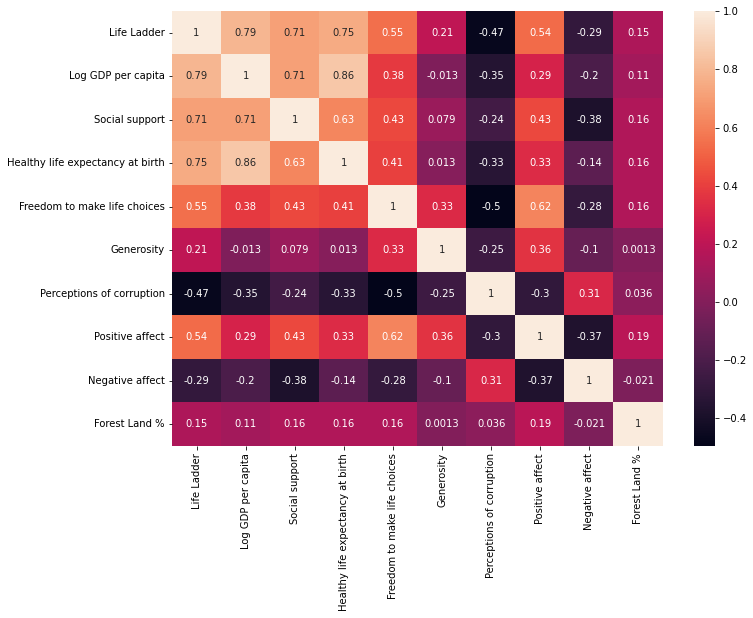

In [38]:
#RS

fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(df_merged_happiness.corr(method='pearson', min_periods=1), annot=True, ax=ax)

As we can see from the above figure, the highest correlations are between:
1. GDP and Healthy Life Exp, Life Ladder, Social Support
2. Life Ladder and GDP, Social Support, Healthy Life Exp, Freedom, Positive affect
3. Social support and Healthy Life
4. Freedom to make life choices and Positive affect

#### Transform speeches to feature vectors by converting them to a matrix of word frequencies

In [39]:
# AK

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

stop_words = stopwords.words('english')
lancaster_stemmer = LancasterStemmer()
speeches = df_merged_happiness['Speech']

def custom_tokenizer(text):
    words = word_tokenize(text)
    cleaned_words = [lancaster_stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words]
    return cleaned_words

# TF vectorizer used for LDA
tf_vectorizer = CountVectorizer(max_df=0.7, min_df=2, tokenizer=custom_tokenizer)

X_train_tf = tf_vectorizer.fit_transform(speeches)

vectorizer_feature_names = tf_vectorizer.get_feature_names()

#### Perform Grid Search to find the best parameters for LDA

In [44]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

grid_search_model = GridSearchCV(lda, param_grid=search_params)

grid_search_model.fit(X_train_tf)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [48]:
# Best Model
best_lda_model = grid_search_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_train_tf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1774939.100436189
Model Perplexity:  1887.941630306917


#### Run LDA

In [49]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

lda_model = LatentDirichletAllocation(n_components=number_of_topics, learning_method='online', learning_offset=50., random_state=0, learning_decay=0.9)
lda_fit = lda_model.fit(X_train_tf)

#### Display info about topics

In [50]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(str(doc_index) + ". " + documents[doc_index][-200:])

#### Visualise topics with pyLDAvis

In [51]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

pyLDAvis_data = pyLDAvis.sklearn.prepare(lda_model, X_train_tf, tf_vectorizer)
pyLDAvis.display(pyLDAvis_data)

#### Add a column containing the dominant topic for each speech

In [52]:
lda_W = lda_model.transform(X_train_tf)
lda_H = lda_model.components_

# Create Document - Topic Matrix
lda_output = lda_model.transform(X_train_tf)

topic_names = ["Topic" + str(i) for i in range(lda_model.n_components)]
doc_names = ["Speech" + str(i) for i in range(len(speeches))]

# Make the pandas dataframe
df_speech_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# Get dominant topic for each document
dominant_topic = np.argmax(df_speech_topic.values, axis=1)

df_merged_happiness['SpeechDominantTopic'] = dominant_topic

# Conclusions: most of the documents have as main subject the climate (stem: clim) and terrorism (stem: ter).

#### Get indices of speeches sorted by relevance to climate

From the above visualization (using pyLDAvis), we observe that the most dominant topic contains the term "clim" as the second most relevant term. So, this is the topic that corresponds to the climate-related speeches and we need to find its index (climate_topic_index).

In [53]:
climate_topic_index = df_merged_happiness.groupby(by=['SpeechDominantTopic']).size().idxmax()

number_of_top_words = 10
number_of_top_documents = 3

topic = lda_H[climate_topic_index]

print("Topic %d:" % (climate_topic_index))
print(" ".join([ (vectorizer_feature_names[i] + " (" + str(topic[i].round(2)) + ")")
  for i in topic.argsort()[:-number_of_top_words - 1:-1]]))

speech_indices_sorted_climate = np.argsort( lda_W[:, climate_topic_index] )[::-1]

Topic 0:
ter (3892.44) clim (3568.86) cris (3285.57) law (2873.64) europ (2689.14) viol (2632.44) agr (2547.37) agend (2498.05) principl (2417.09) poverty (2416.83)


#### Filter speeches related to climate and sort them based on their relevance to climate

In [58]:
df_merged_happiness_copy = df_merged_happiness.copy().reset_index()
climate_speeches_indices = df_merged_happiness_copy.loc[speech_indices_sorted_climate][(df_merged_happiness_copy['SpeechDominantTopic'] == climate_topic_index) 
                                                                                            & (df_merged_happiness_copy['Speech'].str.contains('climat', na=False, case=False))].index.values
climate_speeches_merged_df = df_merged_happiness.iloc[climate_speeches_indices]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
number_of_top_countries = 5

top_country_codes_climate_speeches_number = climate_speeches_merged_df\
                                      .groupby('Country Code')\
                                      .size()\
                                      .sort_values(ascending=False)[:number_of_top_countries]
top_country_codes_climate = list(top_country_codes_climate_speeches_number.index.values)

#### Sort and filter the original merged dataset to contain data about only the top countries regarding climate-related speeches

In [60]:
#SE

top_countries_climate = df_merged_happiness\
                          .sort_values(["Country", "Year", "Life Ladder"], ascending=[True, True, True])\
                          .loc(axis=0)[top_country_codes_climate]
top_countries_climate = top_countries_climate.reset_index()

#### Create visualisation for top N countries which had climate-related speeches to see the relationship between forestation and happiness index

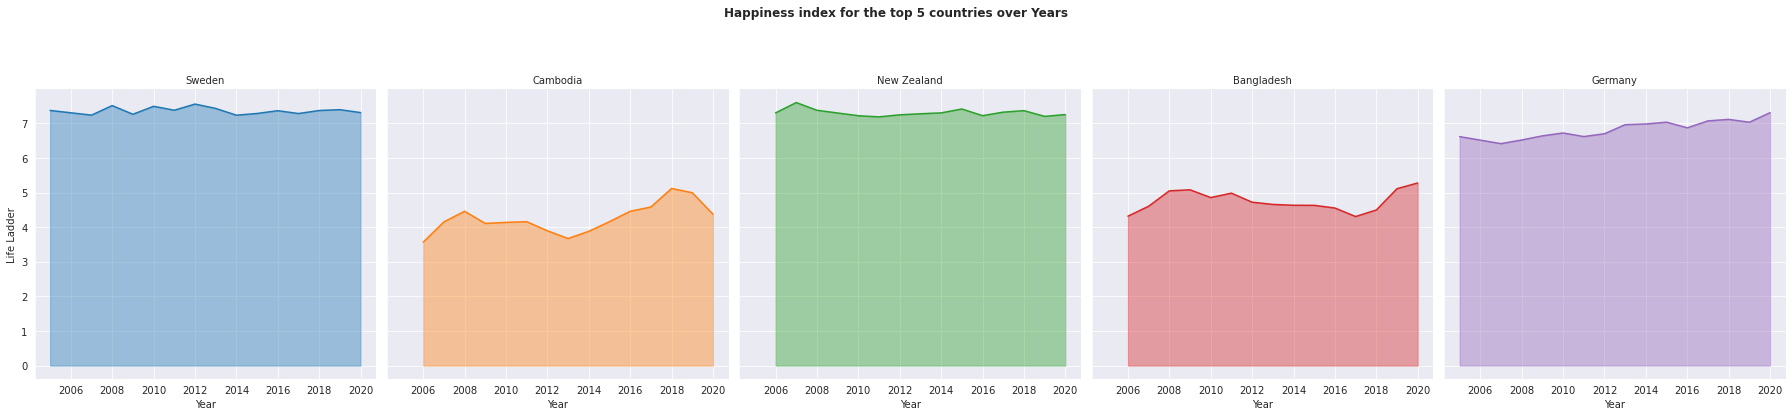

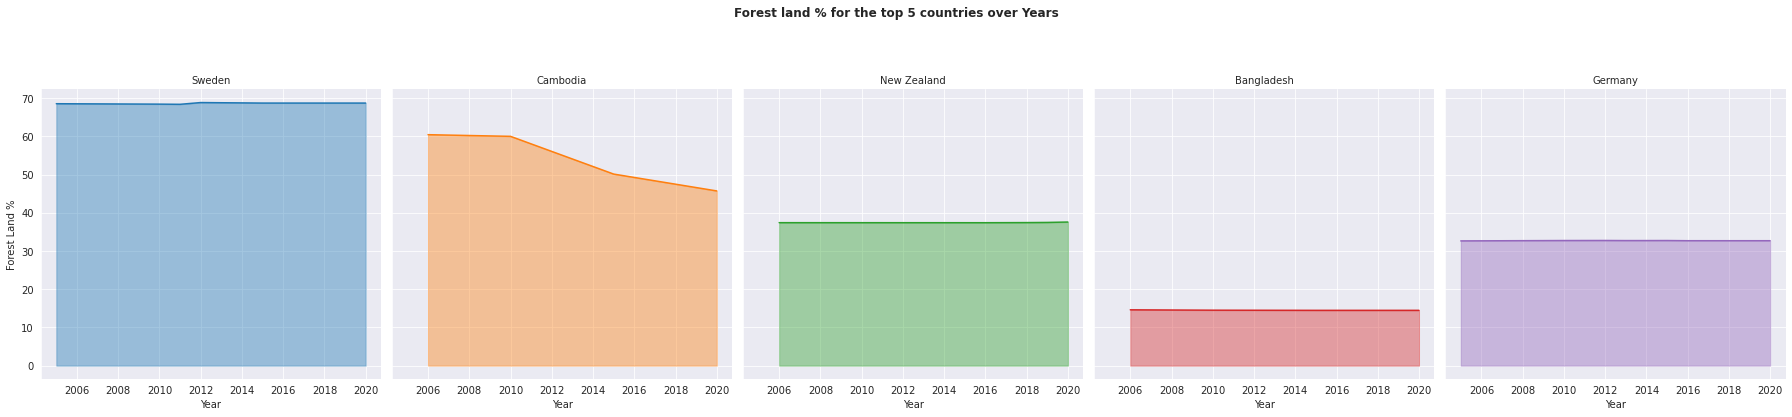

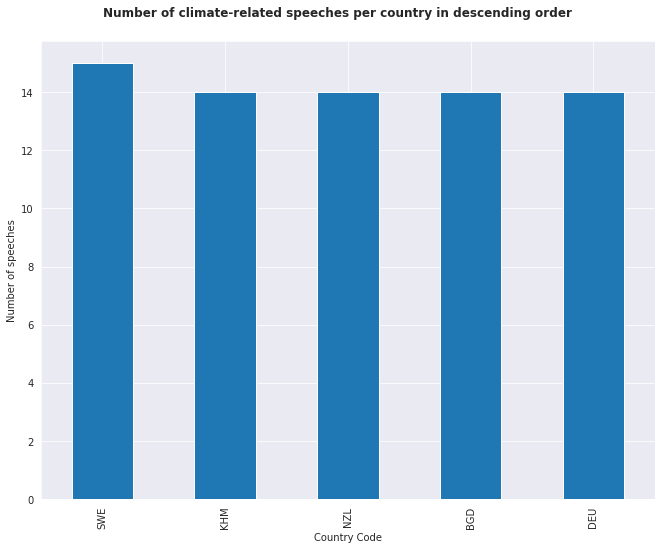

In [61]:
#SE

#small multiples for life ladder
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_style("darkgrid")
g = sns.FacetGrid(top_countries_climate, col='Country', hue='Country', col_wrap=number_of_top_countries, height=5, aspect=1)
g = g.map(plt.plot, 'Year', 'Life Ladder')
g = g.map(plt.fill_between, 'Year', 'Life Ladder', alpha=0.4).set_titles("{col_name} country")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92, )
g = g.fig.suptitle('Happiness index for the top 5 countries over Years', y=1.15, fontweight='bold')
plt.show()

#small multiples for forest %
sns.set_style("darkgrid")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.FacetGrid(top_countries_climate, col='Country', hue='Country', col_wrap=number_of_top_countries, height=5, aspect=1)
g = g.map(plt.plot, 'Year', 'Forest Land %')
g = g.map(plt.fill_between, 'Year', 'Forest Land %', alpha=0.4).set_titles("{col_name} country")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92, )
g = g.fig.suptitle('Forest land % for the top 5 countries over Years', y=1.15, fontweight='bold')
plt.show()

top_country_codes_climate_speeches_number.plot.bar(ylabel='Number of speeches', figsize=(11, 8))
plt.suptitle('Number of climate-related speeches per country in descending order', fontweight='bold')
plt.subplots_adjust(top=0.92, )
plt.show()

#### Find the best parameters to train our model for regression between happiness and deforestation


In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

top_countries_climate = df_merged_happiness.sort_values(["Country", "Year", "Forest Land %"],ascending=[True, True, True])\
                                                              .loc(axis=0)[top_country_codes_climate]

Xtrain = top_countries_climate["Forest Land %"].values
Ytrain = top_countries_climate["Life Ladder"].values

param_grid = {'polynomialfeatures__degree': np.arange(100),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

model = make_pipeline(PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(Xtrain[:, np.newaxis], Ytrain);
grid.best_params_

{'linearregression__fit_intercept': True,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 0}

#### Create a model, with the best parameters found in the above code, to capture the relationship between happiness and deforestation

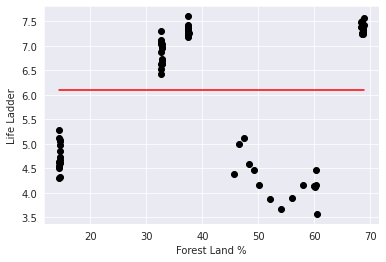

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

polymodel = make_pipeline(PolynomialFeatures(0), LinearRegression(fit_intercept=True))

top_countries_climate.plot.scatter(x="Forest Land %", y="Life Ladder",c='black')

X = top_countries_climate["Forest Land %"].values
Y = top_countries_climate["Life Ladder"].values

polymodel.fit(X[:, np.newaxis], Y)

xfit = np.linspace(min(X), max(X), 1000)
yfit = polymodel.predict(xfit[:, np.newaxis])

axes = plt.gca()

plt.scatter(X, Y, c='black')
plt.plot(xfit, yfit, c='red')